# AGH Modelling of Physical Systems Lab 6 - assignment
Author: Paulina Pojda

**1. particle-resolved random-sampled state representation for an advection problem**

In [1]:
""" notebook code targetting 100% `nbqa pylint` score! :) """

from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot
import scipy
from open_atmos_jupyter_utils import show_plot

In [2]:
PARAMS_P = SimpleNamespace(
    n_part=500,
    norm=1e10,
    dist=scipy.stats.norm(loc=250, scale=50),
)

PARAMS_X = SimpleNamespace(
    span=1000,
    n_cell=25,
)
PARAMS_X.step = PARAMS_X.span / PARAMS_X.n_cell

PARAMS_Y = SimpleNamespace(
    span=1000,
    n_cell=25,
)
PARAMS_Y.step = PARAMS_Y.span / PARAMS_Y.n_cell

PARAMS_2D = SimpleNamespace(
    params_x = PARAMS_X,
    params_y = PARAMS_Y,
)

RNG = np.random.default_rng(seed=44)

In [3]:
def sample(*, params_p, params_2d, rng):
    """ samples a particle population specified onto a grid and returns
    a collection indexed by sampling type, with values composed of `cell` and `mult`
    integer-valued arrays with cell IDs and multiplicities, respectively """
    u01 = rng.uniform(0, 1, params_p.n_part)
    u02 = rng.uniform(0, 1, params_p.n_part)
    return {
        k: {
            'cell': {'x': (v['cell']['x'] / params_2d.params_y.step).astype(int), 
                     'y': (v['cell']['y'] / params_2d.params_y.step).astype(int)},
            'mult': {'x': np.round(v['mult']['x'] * params_p.norm).astype(int), 
                     'y': np.round(v['mult']['y'] * params_p.norm).astype(int)},
        }
        for k,v in
        {
            'sampling: uniform random in x': {
                'cell': {'x': u01 * params_2d.params_x.span, 'y': u02 * params_2d.params_y.span},
                'mult': {'x': params_p.dist.pdf(u01 * params_2d.params_x.span) * 
                         (params_2d.params_x.span/params_p.n_part),
                         'y': params_p.dist.pdf(u02 * params_2d.params_y.span) * 
                         (params_2d.params_y.span/params_p.n_part)},
            },
            'sampling: constant multiplicity': {
                'cell': {'x': params_p.dist.ppf(u01), 'y': params_p.dist.ppf(u02)},
                'mult': {'x': np.full(params_p.n_part, 1/params_p.n_part), 
                         'y': np.full(params_p.n_part, 1/params_p.n_part)},
            }
        }.items()
    }

PARTICLES = sample(params_p=PARAMS_P, params_2d=PARAMS_2D, rng=RNG)

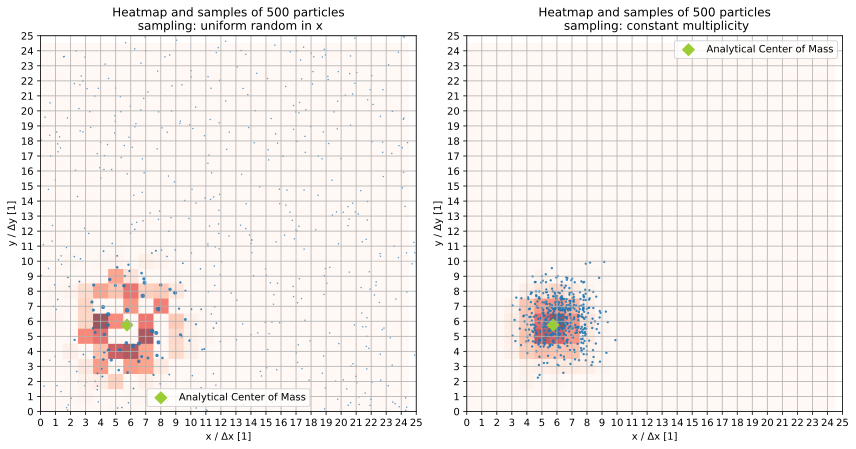

In [4]:
def calculate_analitical_mass_center(params_p, params_x, params_y, shift):
    """ calculates center of the mass of the particles for analitical solution """
    x_centers = (np.arange(params_x.n_cell) + 0.5) * params_x.step
    y_centers = (np.arange(params_y.n_cell) + 0.5) * params_y.step

    x_values, y_values = np.meshgrid(x_centers, y_centers, indexing='ij')

    density_x = params_p.dist.pdf(x_values - shift)
    density_y = params_p.dist.pdf(y_values - shift)
    analytical_density = density_x * density_y

    analytical_density /= analytical_density.sum()

    y_indices, x_indices = np.indices(analytical_density.shape)
    return ((x_indices * analytical_density).sum(), (y_indices * analytical_density).sum())


def plot(*, particles, params_p, params_2d, rng, shift=0):
    """ plots the particle state as both a histogram as well as population scatter 
    plot and analitical center of mass
    (with random coordinates shuffled for the purpose of plotting) """
    _, axs = pyplot.subplot_mosaic(
        [['plot1', 'plot2']],
        figsize=(12, 8),
        tight_layout=True,
    )

    u01_x, u01_y = rng.uniform(0, 1, params_p.n_part), rng.uniform(0, 1, params_p.n_part)
    com = calculate_analitical_mass_center(params_p, params_2d.params_x, params_2d.params_y, shift)

    for k, axes in zip(particles, ['plot1', 'plot2']):
        joint_weights = np.sqrt(particles[k]['mult']['x'] * particles[k]['mult']['y'])

        axs[axes].scatter(
            particles[k]['cell']['x'] + u01_x,
            particles[k]['cell']['y'] + u01_y,
            s=0.25 + 2 * joint_weights / (params_p.norm / params_p.n_part),
            alpha = 0.8
        )

        hist2d, _, _ = np.histogram2d(
            particles[k]['cell']['x'],
            particles[k]['cell']['y'],
            weights=joint_weights / params_p.norm,
            bins=[params_2d.params_x.n_cell, params_2d.params_y.n_cell],
            range=[[0, params_2d.params_x.n_cell], [0, params_2d.params_y.n_cell]],
        )

        axs[axes].imshow(
            hist2d.T,
            cmap='Reds',
            alpha=.666,
            aspect='equal'
        )

        axs[axes].scatter(
            com[0], com[1], s=70, color='yellowgreen', marker='D', label='Analytical Center of Mass'
        )

    for axes in axs.values():
        axes.set_xlim(0, params_2d.params_x.n_cell)
        axes.set_ylim(0, params_2d.params_y.n_cell)
        axes.set_xticks(np.arange(params_2d.params_x.n_cell + 1))
        axes.set_yticks(np.arange(params_2d.params_y.n_cell + 1))
        axes.set_aspect('equal')
        axes.legend()
        axes.grid()

   
    axs['plot1'].set_title(f'Heatmap and samples of {params_p.n_part} particles' \
    '\n sampling: uniform random in x')
    axs['plot1'].set_xlabel('x / Δx [1]')
    axs['plot1'].set_ylabel('y / Δy [1]')

    axs['plot2'].set_title(f'Heatmap and samples of {params_p.n_part} particles' \
    '\n sampling: constant multiplicity')
    axs['plot2'].set_xlabel('x / Δx [1]')
    axs['plot2'].set_ylabel('y / Δy [1]')

    show_plot()

plot(particles=PARTICLES, params_p=PARAMS_P, params_2d=PARAMS_2D, rng=RNG)

**2. Monte-Carlo representation of advection dynamics**

In [5]:
PARAMS_T = SimpleNamespace(
    span = 300,
    n_step = 30,
    wind = 1.5
)
PARAMS_T.step = PARAMS_T.span / PARAMS_T.n_step
PARAMS_T.courant_number = PARAMS_T.wind / PARAMS_X.step * PARAMS_T.step

In [6]:
def advect(*, params_p, params_t, particles, rng):
    """ performs Monte-Carlo advection of the particles """
    probability_of_shift = abs(params_t.courant_number)
    assert probability_of_shift < 1
    sign = int(abs(params_t.courant_number)/params_t.courant_number)

    for _ in range(params_t.n_step):
        shuffled_x = rng.uniform(0, 1, params_p.n_part)
        shuffled_y = rng.uniform(0, 1, params_p.n_part)

        for sampling in particles:
            particles[sampling]['cell']['x'] += (shuffled_x < probability_of_shift)*sign
            particles[sampling]['cell']['y'] += (shuffled_y < probability_of_shift)*sign


        
advect(particles=PARTICLES, params_t=PARAMS_T, params_p=PARAMS_P, rng=RNG)

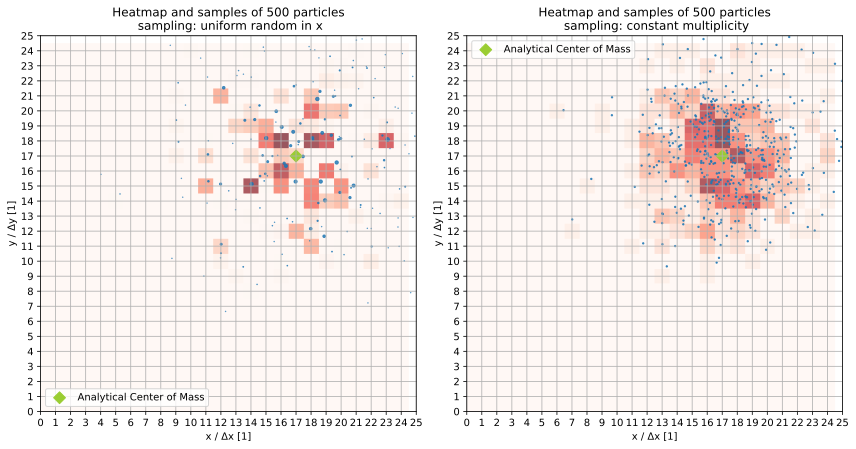

In [7]:
plot(
    particles=PARTICLES,
    params_2d=PARAMS_2D,
    params_p=PARAMS_P,
    rng=RNG,
    shift=PARAMS_T.wind * PARAMS_T.span,
)

# Goal
The goal of this algorythm is to compare two sampling strategies for simulating particle distributions evolve under advection in a 2D space and assess their alignment with an analytical solution reprezented as center of mass.

# Observations and Conclusions
Left Plot – Uniform Random Sampling:

The resulting distribution is spread out with less density in the core region.
There's visible mismatch between the simulated mass distribution and the analytical center of mass.
This method shows higher variance and less accurate tracking of the analytical dynamics before as well as after advection.

Right Plot – Constant Multiplicity Sampling:

Particle weights are more systematically assigned, concentrating in high-probability regions.
The resulting distribution clearly peaks near the analytical center of mass due to better coverage of the areas that actually contribute most.
This approach better approximates the density field which clearly depicts that different types of samplings yield different results.